<a href="https://colab.research.google.com/github/mantzaris/teddyCode/blob/main/Graphical_NN_10_22_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.7.1" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools Plots"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -n "$COLAB_GPU" ] && [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  if [ "$COLAB_GPU" = "1" ]; then
      JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia  

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

In [1]:
import Pkg; Pkg.add("InvertedIndices")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed InvertedIndices ─ v1.1.0
    Updating `~/.julia/environments/v1.7/Project.toml`
  [41ab1584] + InvertedIndices v1.1.0
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [41ab1584] + InvertedIndices v1.1.0
Precompiling project...
  ✓ InvertedIndices
  1 dependency successfully precompiled in 2 seconds (142 already precompiled)


In [2]:
using Plots 
using LinearAlgebra
using BenchmarkTools
import Random
using InvertedIndices
using BenchmarkTools

In [12]:
using InvertedIndices
using Plots 
using LinearAlgebra
using BenchmarkTools
import Random

function make_mtrx(dimentions, list_1, list_2)
  m = zeros(dimentions, dimentions)
  for i in list_1
    for j in list_2
      m[i, j] = 1
    end
  end
  return m
end

function random_matrix_new(a, b, x_dim, y_dim)
  mtrx = rand(a:b, x_dim, y_dim )
  return mtrx
end

function get_zeros_non_zeros(mtrx, x_dim, y_dim)
  s = 0
    for i in range(1, x_dim)
      for j in range(1, y_dim)
        if (a[i, j] == 0.0)
          s = s + 1
        end
      end
    end
    println("Zeros: $s and Non-zeros: ", x_dim * y_dim - s)
  return s
end


function get_matrix_memory(a_down_lim, a_up_lim, a_dim)
  memory_list = Vector{Float64}()
  benchmarkDicts["memory"] = []
  bb = @benchmark random_matrix($a_down_lim, $a_up_lim, $a_dim, $a_dim)
  push!(benchmarkDicts["memory"], bb.memory)
  return(benchmarkDicts["memory"])
end


function random_matrix(a, b, x_dim, y_dim)
  Random.seed!(1234)
  mtrx = rand(a:b, x_dim, y_dim )
  return mtrx
end

function get_each_element(mtrx, x_dim, y_dim)
  for i in range(1, x_dim)
    for j in range(1, y_dim)
     print("mtrx[$i, $j]  = ", mtrx[i, j], "\n")
    end
  end
end

function A2S(AdjMat)
    AdjMat += I #add the identity to the diagonal, add self-loops
    diag = Diagonal(vec(sum(AdjMat,dims=2) .^ (-1/2)))
    return (diag) * AdjMat * (diag) #return the normalized S matrix
end

function initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  #print("\n")
  #println("Making a matrix, this might take some time...")
  a = random_matrix(a_down_lim, a_up_lim, a_dim, a_dim)
  #print("\n")
  #println("Calculating aj matrix, this might take some time...")
  aj = A2S(a)
  #print("\n")
  #println("Making x matrix, this might take some time...")
  x = random_matrix(x_down_lim, x_up_lim, a_dim, x_y_dim)
  #print("\n")
  #println("Making th matrix, this might take some time...")
  th = random_matrix(th_down_lim, th_up_lim, x_y_dim, th_y_dim)
  #print("\n")
  #println("Calculating final matrix, final = aj * x * th ")
  Final = aj * x * th  
  return a, aj, x, th, Final 
end



function reduce_size(a, x, th, n_col_row_to_reduce)
  x_dim = size(a, 1)
  y_dim = size(a, 2)
  a_reduced = a[Not(x_dim - n_col_row_to_reduce: end), Not(y_dim - n_col_row_to_reduce : end)]
  aj_reduced = A2S(a_reduced)
  x_reduced = x[Not(x_dim - n_col_row_to_reduce: end), :]
  Final_reduced = aj_reduced * x_reduced * th
  return Final_reduced
  end


function mae(mtrx, mtrx_reduced)
  x = size(mtrx_reduced, 1)
  y = size(mtrx_reduced, 2)
  s = 0
  for i in range(1, x)
    for j in range(1, y)
      s = s + abs(mtrx[i, j] - mtrx_reduced[i, j])
    end
  end
  mae = sqrt(s/(x*y))
  return mae 
  end
  


function total_error(n_drop_row_col, a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim )
  mean_average_error = Vector{Float64}()
  a, aj, x, th, Final = initial_matrix(a_dims, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  for i in range(-1, n_drop_row_col)
    F1 = reduce_size(a, x, th, i)
    MAE = mae(Final, F1)
    append!(mean_average_error,MAE)
  end
  skip = collect(-1: n_drop_row_col)
  return(mean_average_error, skip)
  end

 function split_alpha_matrix(a_mtrx, n_lines_to_split)
  x = size(a_mtrx, 1)
  y = size(a_mtrx, 2)
  n = div(x, n_lines_to_split)
  dictionary = Dict()
  count = 1
  k = 1
  for i in range(1, n_lines_to_split)
    z = 1
    for j in range(1, n_lines_to_split)
      dictionary["a_$count"] = a_mtrx[k: k + n - 1, z: j*n ]
      count = count + 1
      z = z + n
    end
    k = k + n
  end
  #show(stdout, "text/plain", dictionary["a_1"])
  return(dictionary)
end


function split_x_matrix(x_mtrx, n_lines_to_split)
  x = size(x_mtrx, 1)
  n = div(x, n_lines_to_split)
  #print(n)
  dictionary = Dict()
  z = 1
  for i in range(1, n_lines_to_split)
    dictionary["x_$i"] = x_mtrx[z : z + n - 1 , 1:end]
    z = z + n
  end
  #show(stdout, "text/plain", dictionary["x_3"])
  return(dictionary)
  end 

 function dictionary_to_matrix(dict, x_splited_length, x_y_dim, x_mtrx, n_lines_to_split)
  i = 1 
  mtrx_reduced_dictionary = Dict()
  count = 1
  num = div(size(x_mtrx, 1), n_lines_to_split)
  while (i <= length(dict)) 
    s = zeros(num, x_y_dim)
    k = 1 
    while k <= x_splited_length  
      s = s + dict["aj_x_$i"] 
      k = k + 1 
      i = i + 1
    end 
  mtrx_reduced_dictionary["A_$count"] = s
  count = count + 1
  end 
  s_ = vcat(mtrx_reduced_dictionary["A_1"])
  for i in range(2, length(mtrx_reduced_dictionary))
    aux = vcat(s_, mtrx_reduced_dictionary["A_$i"])
    s_ = aux
  end
  return s_ 
end 


function multiply_splited(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim, n_lines_to_split)
  a_mtrx,  aj_mtrx, x_mtrx, th_mtrx, final_mtrx  = initial_matrix(a_dim, a_down_lim, a_up_lim, x_y_dim, x_down_lim, x_up_lim, th_y_dim, th_down_lim, th_up_lim)
  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  aj_splited = Dict()
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  #show(stdout, "text/plain", aj_splited)
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = dictionary_to_matrix(aj_x, length(x_splited), x_y_dim, x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end


function multiply_splited_2(a_mtrx, x_mtrx, th_mtrx, n_lines_to_split)
  a_splited = split_alpha_matrix(a_mtrx, n_lines_to_split)
  x_splited = split_x_matrix(x_mtrx, n_lines_to_split)
  x_y_dim = size(x_mtrx, 2)
  aj_splited = Dict()
  #print("\n")
  for i in range(1, length(a_splited))
    aj_splited["aj_$i"] = A2S(a_splited["a_$i"])
  end
  #show(stdout, "text/plain", aj_splited)
  aj_x = Dict()
  k = 1
  while k <= length(a_splited)
    for i in range(1, length(x_splited))
      aj_x["aj_x_$k"] = aj_splited["aj_$k"] * x_splited["x_$i"] 
      k = k + 1
    end
  end
  aj_x_mtrx = dictionary_to_matrix(aj_x, length(x_splited), x_y_dim, x_mtrx, n_lines_to_split)
  final = aj_x_mtrx * th_mtrx
  #show(stdout, "text/plain", final)
  return(final)
end


multiply_splited_2 (generic function with 1 method)

In [4]:
error_, skip_ = total_error(200, 1000, 0, 10, 10, -4, 4, 5, -2, 2);

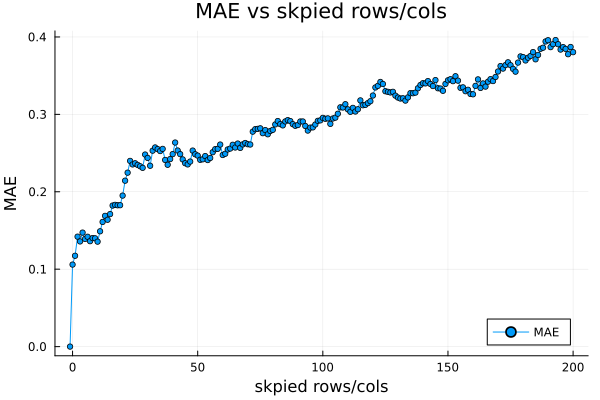

In [5]:
plot(skip_, # x-axis
    error_, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs skpied rows/cols",
    xlabel = "skpied rows/cols",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [6]:
a, aj, x, th, final = initial_matrix(1000, 0, 150, 20, -4, 4, 5, -2, 2);


In [7]:
f = multiply_splited_2(a, x, th, 1);

In [8]:
mae_splited = Vector{Float64}()
for i in range(1, 100)
  f = multiply_splited_2(a, x, th, i);
  mae_spl = mae(final, f);
  append!(mae_splited, mae_spl)
  end

In [9]:
counter = 1
counter_list = Vector{Float64}()
for i in mae_splited
  append!(counter_list, counter)
  counter = counter + 1
end

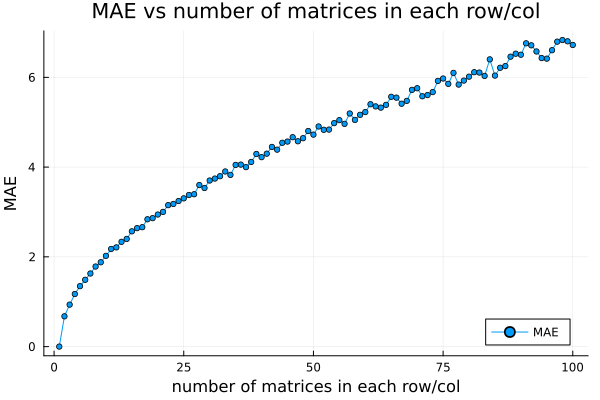

In [10]:
plot(counter_list, # x-axis
    mae_splited, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "MAE vs number of matrices in each row/col",
    xlabel = "number of matrices in each row/col",
    label = "MAE",
    legend=:bottomright,
    ylabel = "MAE")

In [26]:
function random_matrix_new(a, b, x_dim, y_dim)
  mtrx = rand(a:b, x_dim, y_dim )
  return mtrx
end

random_matrix_new (generic function with 1 method)

In [30]:
benchmarkDicts = Dict()
benchmarkDicts["memory"] = []
i_list = []
for i in 1000:1000:10000
  mem = @benchmark random_matrix_new(0, 150, $i, $i);
  push!(benchmarkDicts["memory"], mem.memory/1000000)
  append!(i_list, i)
end
print(benchmarkDicts["memory"])

Any[8.000048, 32.000048, 72.000048, 128.000048, 200.000048, 288.000048, 392.000048, 512.000048, 648.000048, 800.000048]

In [25]:
println(benchmarkDicts["memory"])
println(i_list)

Any[0.080048, 0.320048, 0.720048, 1.280048, 2.000048, 2.880048, 3.920048, 5.120048, 6.480048, 8.000048]
Any[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]


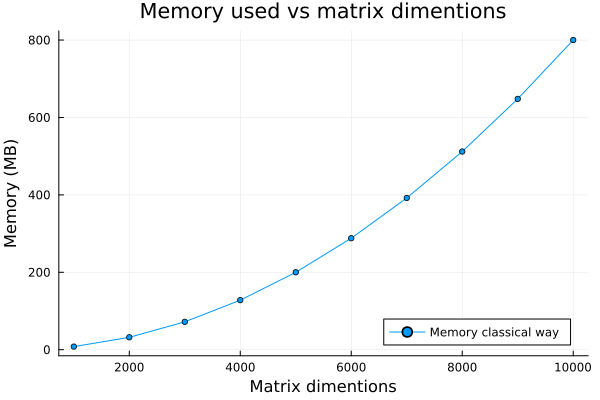

In [31]:
plot(i_list, # x-axis
    benchmarkDicts["memory"], # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Memory classical way",
    legend=:bottomright,
    ylabel = "Memory (MB)")

In [15]:
function create_3(a_dim, final_dim)
  a_test = random_matrix_new(0, 150, a_dim, a_dim)
  a_f_row = a_test
  a_f_col = a_test
  for i in range(1, final_dim/a_dim -1)
    a_f_row = vcat(a_f_row, random_matrix_new(0, 150, a_dim, a_dim))
  end
  for i in range(1, final_dim/a_dim -1)
    a_f_col = hcat(a_f_col, random_matrix_new(0, 150, a_dim, a_dim))
  end
  print("\n")
  ff = a_f_row * a_f_col
  return(ff)
  end

  mat = create_3(1, 550);

In [ ]:
benchmarkDicts1 = Dict()
benchmarkDicts1["memory"] = []
i_list1 = []
for i in 1000:1000:10000
  mem = @benchmark create_3(1, $i);
  push!(benchmarkDicts1["memory"], mem.memory/1000000)
  append!(i_list1, i)
end


In [ ]:
benchmarkDicts10 = Dict()
benchmarkDicts10["memory"] = []
i_list10 = []
for i in 1000:1000:10000
  mem = @benchmark create_3(10, $i);
  push!(benchmarkDicts10["memory"], mem.memory/1000000)
  append!(i_list10, i)
end

In [ ]:
benchmarkDicts1000 = Dict()
benchmarkDicts1000["memory"] = []
i_list1000= []
for i in 1000:1000:10000
  mem = @benchmark create_3(1000, $i);
  push!(benchmarkDicts1000["memory"], mem.memory/1000000)
  append!(i_list1000, i)
end

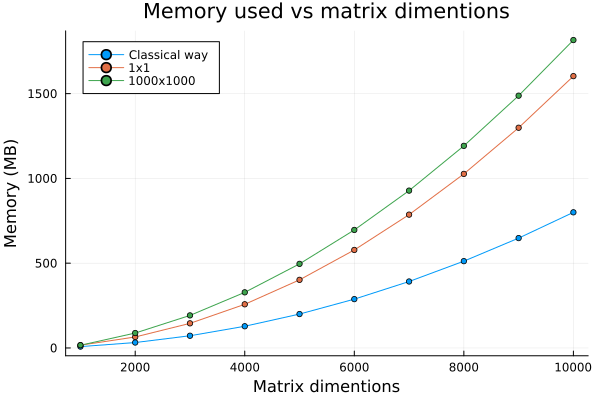

In [34]:
x =  i_list
y = benchmarkDicts["memory"] 

x1 = i_list1
y1 = benchmarkDicts1["memory"] 

x10 = i_list10
y10 = benchmarkDicts10["memory"] 

x1000 = i_list1000
y1000 = benchmarkDicts1000["memory"] 

plot(x, # x-axis
    y, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "Classical way",
    legend=:bottomright,
    ylabel = "Memory (MB)")


    plot!(x1, # x-axis
    y1, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "1x1",
    legend=:topleft,
    ylabel = "Memory (MB)")

    #plot!(x10, # x-axis
    #y10, # yaxis
    #markershape=:circle, 
    #markersize=3,
    #title = "Memory used vs matrix dimentions",
    #xlabel = "Matrix dimentions",
    #label = "10x10",
    #legend=:topleft,
    #ylabel = "Memory (MB)")

    plot!(x1000, # x-axis
    y1000, # yaxis
    markershape=:circle, 
    markersize=3,
    title = "Memory used vs matrix dimentions",
    xlabel = "Matrix dimentions",
    label = "1000x1000",
    legend=:topleft,
    ylabel = "Memory (MB)")